In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import downstream_information
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## load data from session with deep,sup,mec,pfc

In [14]:
basepath = r"Z:\Data\HMC1\day13"

# load in spike data
st, cm = loading.load_spikes(
    basepath, putativeCellType="Pyr"
)
cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

# ripple expansion start, in seconds, how much to expand ripples
rip_exp_start=0.05  
rip_exp_stop=0.2
ripples_df = loading.load_ripples_events(basepath)
ripples = (
    nel.EpochArray(np.array([ripples_df.start, ripples_df.stop]).T)
    .expand(rip_exp_start, direction="start")
    .expand(rip_exp_stop, direction="stop")
)

## get firing rate in each ripple

In [79]:
ripple_mat = functions.get_participation(
    st.data, ripples.starts, ripples.stops, par_type="firing_rate"
)

## SWR firing rate plot

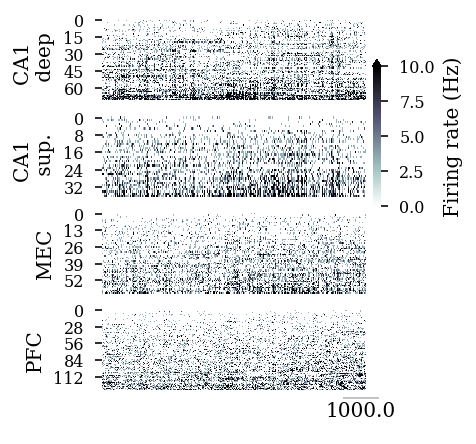

In [279]:
from ripple_heterogeneity.utils import scalebars

fig, axs = plt.subplots(
    4,
    1,
    figsize=functions.set_size("thesis", fraction=.4, subplots=(7, 3)),
    sharex=True,
)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
axs = axs.ravel()

cbar_ax = fig.add_axes([0.92, 0.5, 0.025, 0.3])

X = ripple_mat[
    cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"), :
]
X = X[np.argsort(X.mean(axis=1)), :]
sns.heatmap(
    X,
    ax=axs[0],
    vmax=10,
    vmin=0,
    cmap="bone_r",
    cbar_kws={"label": "Firing rate (Hz)", "extend": "max"},
    cbar_ax=cbar_ax,
    cbar=True,
    rasterized=True
)

X = ripple_mat[
    cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"),
    :,
]
X = X[np.argsort(X.mean(axis=1)), :]
sns.heatmap(
    X,
    ax=axs[1],
    vmax=10,
    vmin=0,
    cmap="bone_r",
    cbar=False,
    rasterized=True
)

X = ripple_mat[cm.brainRegion.str.contains("MEC"), :]
X = X[np.argsort(X.mean(axis=1)), :]
sns.heatmap(X, ax=axs[2], vmax=10, vmin=0, cmap="bone_r", cbar=False, rasterized=True)

X = ripple_mat[cm.brainRegion.str.contains("PFC"), :]
X = X[np.argsort(X.mean(axis=1)), :]
sns.heatmap(X, ax=axs[3], vmax=10, vmin=0, cmap="bone_r", cbar=False, xticklabels=1000,rasterized=True)

sb = scalebars.add_scalebar(
    axs[3], matchx=True, matchy=False, hidex=True, hidey=False, pad=-2
)

axs[0].xaxis.set_visible(False)
axs[1].xaxis.set_visible(False)
axs[2].xaxis.set_visible(False)

axs[0].set_ylabel("CA1 \n deep")
axs[1].set_ylabel("CA1 \n sup.")

axs[2].set_ylabel("MEC")
axs[3].set_ylabel("PFC")

axs[3].set_xlabel("Concatenated SWR")

plt.savefig(
    os.path.join(fig_save_path, "ripple_fr_4_regions.svg"),
    dpi=600,
    bbox_inches="tight",
)
plt.show()


In [327]:
x_ca1_sup = ripple_mat[cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"), :]
x_ca1_sup = x_ca1_sup[np.argsort(x_ca1_sup.mean(axis=1)), :]

x_ca1_deep = ripple_mat[cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"), :]
x_ca1_deep = x_ca1_deep[np.argsort(x_ca1_deep.mean(axis=1)), :]

x_mec = ripple_mat[cm.brainRegion.str.contains("MEC"), :]
x_mec = x_mec[np.argsort(x_mec.mean(axis=1)), :]

x_pfc = ripple_mat[cm.brainRegion.str.contains("PFC"), :]
x_pfc = x_pfc[np.argsort(x_pfc.mean(axis=1)), :]

x_ca1_sup.shape[0], x_ca1_deep.shape[0], x_mec.shape[0], x_pfc.shape[0]

(37, 71, 63, 135)

## calculate pairwise mutual information to locate nice pairs

In [121]:
mi,pairs = downstream_information.pairwise_info(ripple_mat, return_index=True)

In [127]:
results_temp = downstream_information.make_df(
    mi,
    pairs,
    cm,
    "mutual_info",
    "CA1",
    ["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"],
)

In [207]:
print("deep mec")
display(results_temp[results_temp.label=="deep_mec"].sort_values(by=["mutual_info"], ascending=True).head())

print("sup mec")
display(results_temp[results_temp.label=="sup_mec"].sort_values(by=["mutual_info"], ascending=False).head())


print("deep pfc")
display(results_temp[results_temp.label=="deep_pfc"].sort_values(by=["mutual_info"], ascending=False).head())

print("sup pfc")
display(results_temp[results_temp.label=="sup_pfc"].sort_values(by=["mutual_info"], ascending=True).head())



deep mec


,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid
13534,0.000983,deep_mec,277,333,CA1so,MEC,415,496
12778,0.001324,deep_mec,261,333,CA1so,MEC,396,496
13219,0.001826,deep_mec,269,333,CA1so,MEC,405,496
9817,0.002103,deep_mec,172,333,CA1so,MEC,281,496
12652,0.002163,deep_mec,257,333,CA1so,MEC,390,496


sup mec


,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid
20649,0.377240,sup_mec,238,311,CA1sr,MEC,368,464
21342,0.338310,sup_mec,280,311,CA1sr,MEC,420,464
19893,0.304786,sup_mec,198,311,CA1sr,MEC,312,464
20964,0.304471,sup_mec,247,311,CA1sr,MEC,378,464
20661,0.303866,sup_mec,238,323,CA1sr,MEC,368,481


deep pfc


,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid
4071,0.376507,deep_pfc,57,214,PFC,CA1so,89,335
4088,0.369004,deep_pfc,57,239,PFC,CA1so,89,369
4115,0.365642,deep_pfc,57,286,PFC,CA1so,89,428
2668,0.355296,deep_pfc,37,239,PFC,CA1so,54,369
4585,0.350214,deep_pfc,64,239,PFC,CA1so,104,369


sup pfc


,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid
18964,0.000616,sup_pfc,132,231,PFC,CA1sr,215,360
18942,0.000947,sup_pfc,132,170,PFC,CA1sr,215,278
18962,0.000989,sup_pfc,132,218,PFC,CA1sp,215,343
18976,0.000993,sup_pfc,132,260,PFC,CA1sr,215,395
18113,0.001019,sup_pfc,109,231,PFC,CA1sr,172,360


In [199]:
# display(results_temp[results_temp.label=="sup_pfc"].sort_values(by=["mutual_info"], ascending=True).head())
results_temp.groupby(["reference_id","target_id"]).max().sort_values(by=["mutual_info"], ascending=False)

,,mutual_info,label,reference,target,reference_uid,target_uid
reference_id,target_id,,,,,,
214,311,0.414203,deep_mec,CA1so,MEC,335,464
286,311,0.405662,deep_mec,CA1so,MEC,428,464
239,311,0.401202,deep_mec,CA1so,MEC,369,464
224,311,0.385323,deep_mec,CA1so,MEC,350,464
238,311,0.377240,sup_mec,CA1sr,MEC,368,464
...,...,...,...,...,...,...,...
132,218,0.000989,sup_pfc,PFC,CA1sp,215,343
277,333,0.000983,deep_mec,CA1so,MEC,415,496
132,268,0.000956,deep_pfc,PFC,CA1so,215,404


In [216]:
results_temp.groupby("label").median()

,mutual_info,reference_id,target_id,reference_uid,target_uid
label,,,,,
deep_mec,0.071134,228.0,321.0,355.0,479.0
deep_pfc,0.068031,67.0,228.0,110.0,355.0
sup_mec,0.066557,207.0,321.0,324.0,479.0
sup_pfc,0.065637,67.0,207.0,110.0,324.0


In [211]:
results_temp[results_temp.reference_id == 57].sort_values(by=["mutual_info"], ascending=True)

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid
16189,0.037429,sup_pfc,57,231,PFC,CA1sr,89,360
4066,0.037834,deep_pfc,57,208,PFC,CA1so,89,325
16198,0.040415,sup_pfc,57,248,PFC,CA1sr,89,379
16167,0.049060,sup_pfc,57,170,PFC,CA1sr,89,278
4064,0.050128,deep_pfc,57,203,PFC,CA1so,89,318
...,...,...,...,...,...,...,...,...
16192,0.348584,sup_pfc,57,238,PFC,CA1sr,89,368
4079,0.349864,deep_pfc,57,224,PFC,CA1so,89,350
4115,0.365642,deep_pfc,57,286,PFC,CA1so,89,428
4088,0.369004,deep_pfc,57,239,PFC,CA1so,89,369


(0.0, 353.0, 353.0, 0.0)

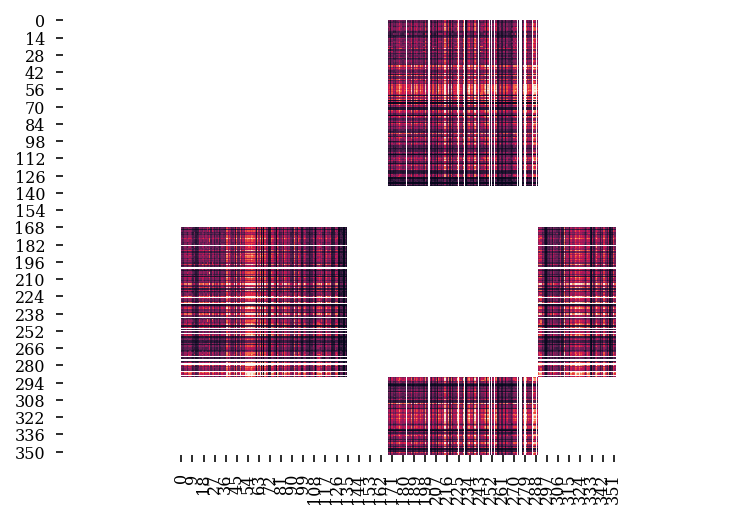

In [231]:
X = np.ones([ripple_mat.shape[0],ripple_mat.shape[0]]) *np.nan
X[results_temp.reference_id,results_temp.target_id] = results_temp.mutual_info
X[results_temp.target_id,results_temp.reference_id] = results_temp.mutual_info

# np.max([results_temp.reference_id.max(), results_temp.target_id.max()])
sns.heatmap(X, vmax=.25, vmin=0, cbar=False)
plt.axis("equal")

In [ ]:
display(results_temp[(results_temp.label=="deep_mec") & (results_temp.mutual_info > .1)].sort_values(by=["mutual_info"], ascending=True).head(20))


## example pairs plot

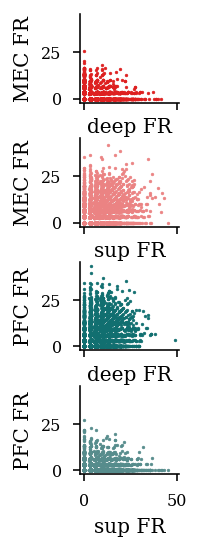

In [323]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}

fig, axs = plt.subplots(4,1,
    figsize=functions.set_size("thesis", fraction=.2, subplots=(5.8, 1)),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(hspace=0.4, wspace=0.1)
axs = axs.ravel()

axs[0].scatter(ripple_mat[289],ripple_mat[313],label="deep_mec",s=2,color=group_colors["deep_mec"], rasterized=True)
axs[1].scatter(ripple_mat[238],ripple_mat[311],label="sup_mec",s=2,color=group_colors["sup_mec"], rasterized=True)
axs[2].scatter(ripple_mat[214],ripple_mat[57],label="deep_pfc",s=2,color=group_colors["deep_pfc"], rasterized=True)
axs[3].scatter(ripple_mat[238],ripple_mat[51],label="sup_pfc",s=2,color=group_colors["sup_pfc"], rasterized=True)


axs[0].set_xlabel("deep FR")
axs[0].set_ylabel("MEC FR")

axs[1].set_xlabel("sup FR")
axs[1].set_ylabel("MEC FR")

axs[2].set_xlabel("deep FR")
axs[2].set_ylabel("PFC FR")

axs[3].set_xlabel("sup FR")
axs[3].set_ylabel("PFC FR")

sns.despine()

axs[0].set_aspect('equal', 'box')
axs[1].set_aspect('equal', 'box')
axs[2].set_aspect('equal', 'box')
axs[3].set_aspect('equal', 'box')

plt.savefig(
    os.path.join(fig_save_path, "single_cell_SWR_fr_examples.svg"),
    dpi=600,
    bbox_inches="tight",
    transparent=True
)